## Custom Datasets: Using Data of your own in Torchvision

In [1]:
import torch
from torch import nn
import pathlib
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


### Kaggle Brain Tumour MRI Dataset Preprocessing -> data paths
This dataset contains ~1300 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

In [ ]:
data_path = Path('./data')
image_path = data_path / 'images'

if image_path.is_dir():
    print('Images folder exists')
else:
    print('Creating folder for images')
    image_path.mkdir(parents=True, exist_ok=True)

Images folder exists


In [ ]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'{len(dirnames)} directories and {len(filenames)} images in {dirpath}')
walk_through_dir(image_path)

In [2]:
data_path = Path('./data')
image_path = data_path / 'images'
train_dir = image_path / "Training"
test_dir = image_path / "Testing"
train_dir

WindowsPath('data/images/Training')

### Visualising the Data: a) my attempt c) Daniel Bourke attempt

In [ ]:
#Visualising random images from here
file_collections = ['glioma','meningioma','pituitary','notumor']
random_images = []

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8, 2))

for file in file_collections:
    path = image_path / 'Training' / file
    random_image = np.random.choice([f for f in os.listdir(path) if f.endswith('.jpg')])
    random_images.append(random_image)

ax1.imshow(plt.imread(image_path / 'Training' / file_collections[0] / random_images[0]))
ax2.imshow(plt.imread(image_path / 'Training' / file_collections[1] / random_images[1]))
ax3.imshow(plt.imread(image_path / 'Training' / file_collections[2] / random_images[2]))
ax4.imshow(plt.imread(image_path / 'Training' / file_collections[3] / random_images[3]))


In [ ]:
 fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()  # This turns the 2x2 array into a 1D array of 4 axes

for i, (file, ax) in enumerate(zip(file_collections, axes)):
    img_path = image_path / 'Training' / file / random_images[i]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(file)
    ax.axis('off')

plt.tight_layout()
plt.show() 

In [ ]:
 import random
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False); 

## Transforming the Data:
### Using Datasets and Dataloaders from torch and creating your own dataset and dataloading fxns.classes

### Importing and basic transforming

In [3]:
from torch.utils.data import Dataset, DataLoader 
from torchvision import datasets, transforms

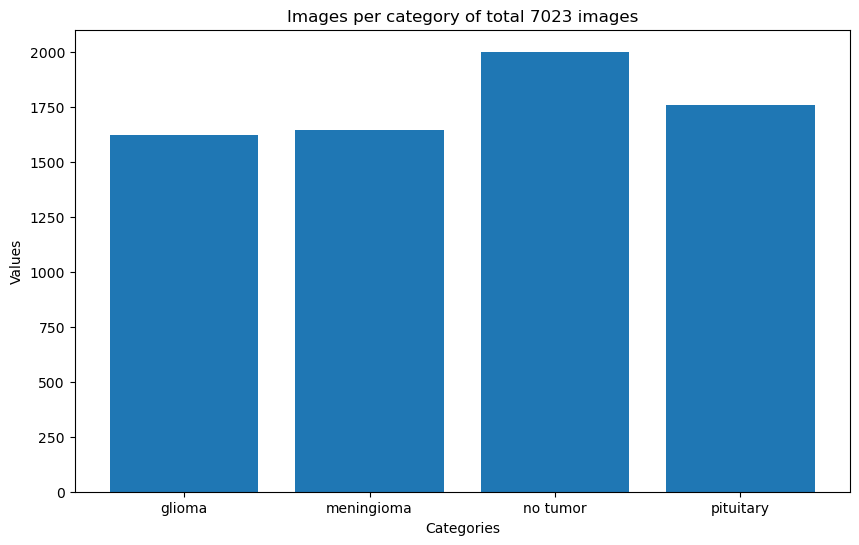

In [4]:
import random
from PIL import Image
all_image_paths = list(image_path.glob('*/*/*.jpg'))
#Pick a random image and check it's dimensions
random_image_path = random.choice(all_image_paths)
img = Image.open(random_image_path)


glioma_path = list(image_path.glob('*/glioma/*.jpg'))
mening_path = list(image_path.glob('*/meningioma/*.jpg'))
no_tumor_path = list(image_path.glob('*/notumor/*.jpg'))
pit_path = list(image_path.glob('*/pituitary/*.jpg'))

# Assuming you have data to plot
categories = ['glioma', 'meningioma', 'no tumor', 'pituitary']
values = [len(glioma_path), len(mening_path), len(no_tumor_path), len(pit_path)]

plt.figure(figsize=(10, 6))
plt.bar(categories, values)
plt.title(f'Images per category of total {len(all_image_paths)} images')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.show()


### My attempt at converting all images to tensors. Worked but didn't realise that with this method I didn't attach any labels to the pictures :(

In [ ]:
 Converting random images to pytorch tensors and homogenising color channels as well i.e if it has 3 channels, convert it to 1 channel
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(img)
tensor_image = transform_image(img)
if tensor_image.shape[0] == 3:
    print(f'This was {tensor_image.shape[0]}!!!!')
    tensor_image = tensor_image.mean(dim=0, keepdim=True)
plt.imshow(tensor_image.permute(1, 2, 0))
plt.title(f'{image_class} with shape {tensor_image.shape}') 

In [ ]:
 tensored_images = []
for image_path in all_image_paths:
    img = Image.open(image_path)
    tensor_image = transform_image(img)
    if tensor_image.shape[0] == 3:
        tensor_image = tensor_image.mean(dim=0, keepdim=True)
    tensored_images.append(tensor_image)
     

'tensored_images = []\nfor image_path in all_image_paths:\n    img = Image.open(image_path)\n    tensor_image = transform_image(img)\n    if tensor_image.shape[0] == 3:\n        tensor_image = tensor_image.mean(dim=0, keepdim=True)\n    tensored_images.append(tensor_image)\n    '

In [ ]:
 rdm_tensor = tensored_images[torch.randint(0, len(tensored_images), (1,))]
plt.imshow(rdm_tensor.squeeze(0).numpy()) 

### Actually transforming with daniel

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[(-1.3080 + -1.2077 + -0.9801)/3], std=[(0.8160 + 0.8342 + 0.8305/3)])
    ])

transform_normal = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_basic = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [6]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=transform_image,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=transform_image,
)


In [ ]:
 img, label = train_data[random.randint(0, len(train_data)-1)]

img.squeeze().shape
plt.imshow(img.squeeze().permute(1,2,0)) 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


(-0.5, 63.5, 63.5, -0.5)

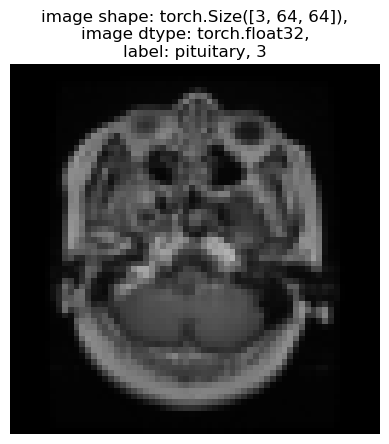

In [7]:
print(train_data.class_to_idx)
rdidx = torch.randint(0, len(train_data), (1,)).item()
img, label = train_data[rdidx][0], train_data[rdidx][1]
plt.title(f'image shape: {img.shape},\nimage dtype: {img.dtype},\nlabel: {train_data.classes[label]}, {label}')
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')

### Datasets to Dataloaders

In [8]:
import torch.utils.data as data

train_dataloader = data.DataLoader(dataset= train_data, batch_size=32, shuffle=True)
test_dataloader = data.DataLoader(dataset= test_data, batch_size=32, shuffle=True)

In [ ]:
 channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for data, _ in train_dataloader:
    print(data.shape)
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
print(mean, std) 


(-0.5, 63.5, 63.5, -0.5)

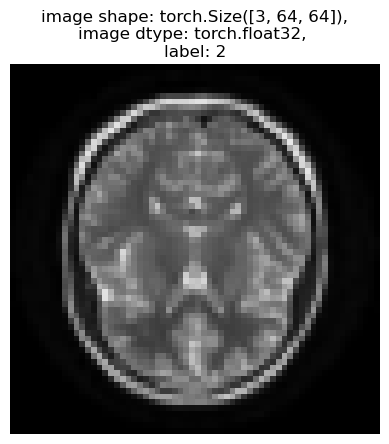

In [9]:
img, label = next(iter(train_dataloader))
sampleimg, samplelbl = img[0], label[0]
plt.title(f'image shape: {sampleimg.shape},\nimage dtype: {sampleimg.dtype}, \nlabel: {samplelbl}')
plt.imshow(sampleimg.permute(1, 2, 0))
plt.axis('off')

### Custom Functions for Dataloading and Datasetting

### Copying MEDMNIST Model Onto Here

In [ ]:
 #Create a training loop
#Loop through epoch, then per train batch, calculate train loss PER BATCH, followed by the same for testing batches
start_time = timer()
loss_o_time = []
 # Assuming 10 classes, adjust if different


epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  model.train()
  for batch, (X, y) in enumerate(train_dataloader):
    y_pred = model(X)
    #y = y.long()
    print(y_pred.size(), y.size())
    break
    loss = loss_function(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_classes = torch.argmax(y_pred, dim=1)
    accuracy.update(y_pred_classes, y)
    if batch % 20 == 0:
      acc = accuracy.compute()
      print(f'Batch: {batch} | Train loss: {train_loss:.4f} | Accuracy: {acc:.4f}')
    loss_o_time.append(train_loss)
    train_loss = 0
      
  train_loss /= len(train_dataloader)

plt.plot(loss_o_time) 


In [17]:
# Modified 2D CNN and Convolutional Autoencoder model from https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02114-6

class Modified2DCNN(nn.Module):
    def __init__(self):
        super(Modified2DCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.encoder = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(46208, 128),
        nn.ReLU(),
        nn.Linear(128, 4)
        )
    
    def forward(self, x):
        conv = self.conv_layers(x)
        encoded = self.encoder(conv)
        classified = self.classifier(encoded.view(encoded.size(0), -1))
        return classified


In [20]:
class PathMNISTModel1(nn.Module):
  def __init__(self,):
    super().__init__()
    #Make a CNN here
    self.block1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size= 2, stride = 2),)
    self.block2 = nn.Sequential(
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2),
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(10*16*16, 128),
      nn.ReLU(),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x) 
    x = self.classifier(x)
    return x


def train_step(model: torch.nn.Module, device: torch.device, train_dataloader, loss_fxn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy):
    loss_o_time = []
    acc_o_time = []
    train_loss = 0
    model.train().to(device)
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fxn(preds, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds_accuracy = torch.argmax(preds, dim=1)
        accuracy.update(preds_accuracy, y)
        acc_o_time.append((accuracy.compute()))
        loss_o_time.append(train_loss)
        if batch % 20 == 0:
            acc = (accuracy.compute())*100
            print(f"Train Batch: {batch} | Train loss: {train_loss:.4f} | Train Accuracy: {acc:.2f} % |")
        train_loss = 0
    plot_loss_acc(loss_o_time, acc_o_time)

def plot_loss_acc(loss_o_time, acc_o_time):
    fig, ax1 = plt.subplots()
    ax1.plot(loss_o_time, label='Loss')
    ax2 = ax1.twinx()
    ax2.plot(acc_o_time, label='Accuracy', color='orange')
    plt.xlabel('Batch')
    plt.legend()
    plt.show()

def test_step(model: torch.nn.Module, device: torch.device, test_dataloader: torch.utils.data.DataLoader, loss_fxn: torch.nn.Module, accuracy):
    model.eval().to(device)
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            test_preds = model(X)
            test_loss += loss_fxn(test_preds, y)
            test_preds_accuracy = torch.argmax(test_preds, dim=1)
            accuracy.update(test_preds_accuracy, y)
            if batch % 50 == 0:
                acc = (accuracy.compute())*100
                print(f"Test Batch: {batch} | Test loss: {test_loss:.4f} | Test Accuracy: {acc:.2f} %")
            test_loss = 0




In [11]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader

In [12]:
Encoder = Modified2DCNN()

In [13]:
testor = torch.randn(32, 3, 64, 64)
output = Encoder(testor)
output.shape

torch.Size([32, 4])

In [18]:
model_retry = PathMNISTModel1()

In [183]:
model2 = PathMNISTModel1()

In [219]:
model3 = PathMNISTModel1()

In [14]:
#Setting up a args for training and test step

device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Encoder.parameters(), lr=0.01)

In [15]:
#Accuracy Functions
#import torchmetrics
from torch import tensor
#from torchmetrics.classification import MulticlassAccuracy
#Timing functions
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import Accuracy
accuracy = Accuracy(task="multiclass", num_classes=4).to(device) 

## Model 4:
Modified 2D CNN & Autoencoder network from research article

  0%|          | 0/1 [00:00<?, ?it/s]

Train Batch: 0 | Train loss: 1.3825 | Train Accuracy: 27.55 % |
Train Batch: 20 | Train loss: 1.3923 | Train Accuracy: 27.33 % |
Train Batch: 40 | Train loss: 1.3846 | Train Accuracy: 27.45 % |
Train Batch: 60 | Train loss: 1.3779 | Train Accuracy: 27.48 % |
Train Batch: 80 | Train loss: 1.3765 | Train Accuracy: 27.60 % |
Train Batch: 100 | Train loss: 1.3683 | Train Accuracy: 27.57 % |
Train Batch: 120 | Train loss: 1.3724 | Train Accuracy: 27.77 % |
Train Batch: 140 | Train loss: 1.3961 | Train Accuracy: 27.78 % |
Train Batch: 160 | Train loss: 1.3577 | Train Accuracy: 27.77 % |


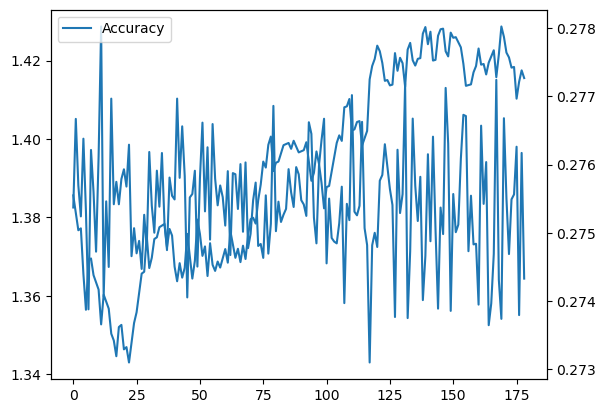

Test Batch: 0 | Test loss: 1.3531 | Test Accuracy: 27.78 %


In [21]:
epochs = 1
for epoch in tqdm(range(epochs)):
    train_step(Encoder, device, train_dataloader, loss_function, optimizer, accuracy)
    test_step(Encoder, device, test_dataloader, loss_function, accuracy)

## Model 1:
Epochs 10, lr = 0.01, no normalisation,
### Results:
accuracy increasing very slowly but steadily, and loss decreasing slowly as well. Test batch had the highest accuracy @ 81.81% and random_image_test shows about the same as well.

  0%|          | 0/10 [00:00<?, ?it/s]

Train Batch: 0 | Train loss: 2.2973 | Train Accuracy: 25.00 % |
Train Batch: 20 | Train loss: 1.3398 | Train Accuracy: 31.40 % |
Train Batch: 40 | Train loss: 1.3457 | Train Accuracy: 28.51 % |
Train Batch: 60 | Train loss: 1.1913 | Train Accuracy: 32.12 % |
Train Batch: 80 | Train loss: 1.3290 | Train Accuracy: 35.07 % |
Train Batch: 100 | Train loss: 0.8936 | Train Accuracy: 39.29 % |
Train Batch: 120 | Train loss: 0.8576 | Train Accuracy: 42.17 % |
Train Batch: 140 | Train loss: 1.1664 | Train Accuracy: 45.46 % |
Train Batch: 160 | Train loss: 0.9489 | Train Accuracy: 46.56 % |


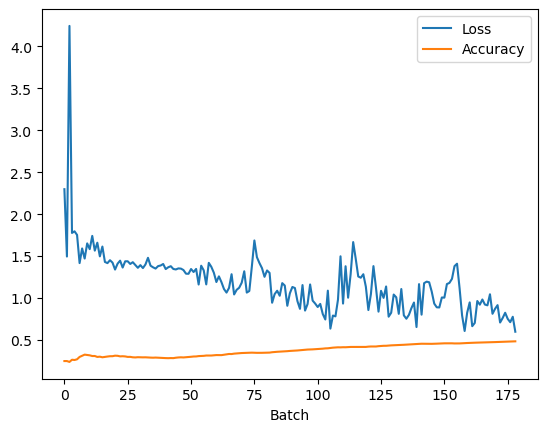

Test Batch: 0 | Test loss: 0.8004 | Test Accuracy: 48.57 %
Train Batch: 0 | Train loss: 0.6137 | Train Accuracy: 52.10 % |
Train Batch: 20 | Train loss: 0.4686 | Train Accuracy: 53.68 % |
Train Batch: 40 | Train loss: 0.9354 | Train Accuracy: 55.45 % |
Train Batch: 60 | Train loss: 0.8023 | Train Accuracy: 56.13 % |
Train Batch: 80 | Train loss: 0.4078 | Train Accuracy: 57.19 % |
Train Batch: 100 | Train loss: 0.4886 | Train Accuracy: 58.55 % |
Train Batch: 120 | Train loss: 0.8747 | Train Accuracy: 59.26 % |
Train Batch: 140 | Train loss: 0.6579 | Train Accuracy: 60.06 % |
Train Batch: 160 | Train loss: 0.6394 | Train Accuracy: 60.96 % |


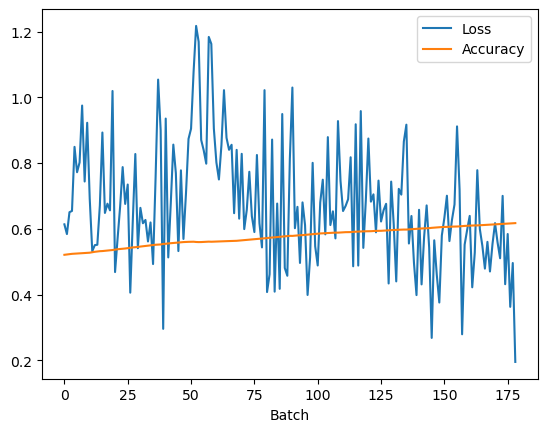

Test Batch: 0 | Test loss: 0.4490 | Test Accuracy: 61.80 %
Train Batch: 0 | Train loss: 0.5592 | Train Accuracy: 62.96 % |
Train Batch: 20 | Train loss: 0.4031 | Train Accuracy: 63.69 % |
Train Batch: 40 | Train loss: 0.5421 | Train Accuracy: 64.34 % |
Train Batch: 60 | Train loss: 0.5385 | Train Accuracy: 65.03 % |
Train Batch: 80 | Train loss: 0.7385 | Train Accuracy: 65.59 % |
Train Batch: 100 | Train loss: 0.6239 | Train Accuracy: 66.13 % |
Train Batch: 120 | Train loss: 0.4153 | Train Accuracy: 66.57 % |
Train Batch: 140 | Train loss: 0.6756 | Train Accuracy: 66.98 % |
Train Batch: 160 | Train loss: 0.4801 | Train Accuracy: 67.28 % |


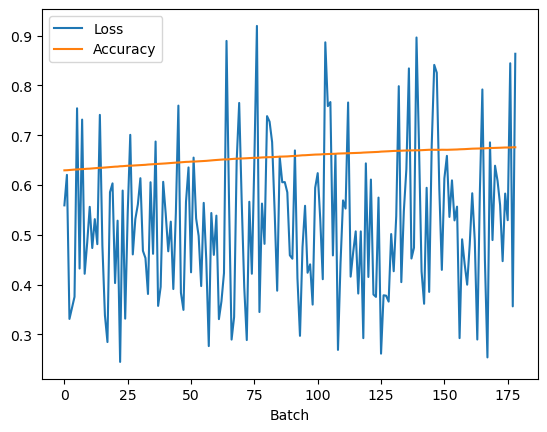

Test Batch: 0 | Test loss: 0.6492 | Test Accuracy: 67.61 %
Train Batch: 0 | Train loss: 0.3979 | Train Accuracy: 68.23 % |
Train Batch: 20 | Train loss: 0.3431 | Train Accuracy: 68.73 % |
Train Batch: 40 | Train loss: 0.3161 | Train Accuracy: 69.22 % |
Train Batch: 60 | Train loss: 0.5234 | Train Accuracy: 69.68 % |
Train Batch: 80 | Train loss: 0.5829 | Train Accuracy: 69.97 % |
Train Batch: 100 | Train loss: 0.4867 | Train Accuracy: 70.27 % |
Train Batch: 120 | Train loss: 0.6392 | Train Accuracy: 70.65 % |
Train Batch: 140 | Train loss: 0.4348 | Train Accuracy: 71.03 % |
Train Batch: 160 | Train loss: 0.3120 | Train Accuracy: 71.32 % |


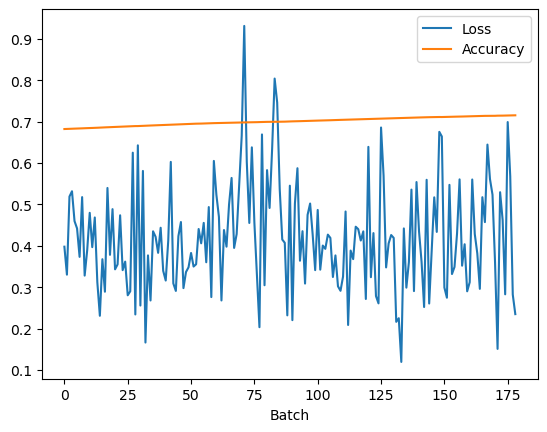

Test Batch: 0 | Test loss: 0.3811 | Test Accuracy: 71.56 %
Train Batch: 0 | Train loss: 0.3306 | Train Accuracy: 71.92 % |
Train Batch: 20 | Train loss: 0.1635 | Train Accuracy: 72.22 % |
Train Batch: 40 | Train loss: 0.3219 | Train Accuracy: 72.49 % |
Train Batch: 60 | Train loss: 0.3916 | Train Accuracy: 72.77 % |
Train Batch: 80 | Train loss: 0.5671 | Train Accuracy: 73.07 % |
Train Batch: 100 | Train loss: 0.4800 | Train Accuracy: 73.34 % |
Train Batch: 120 | Train loss: 0.4972 | Train Accuracy: 73.60 % |
Train Batch: 140 | Train loss: 0.5240 | Train Accuracy: 73.84 % |
Train Batch: 160 | Train loss: 0.2360 | Train Accuracy: 74.05 % |


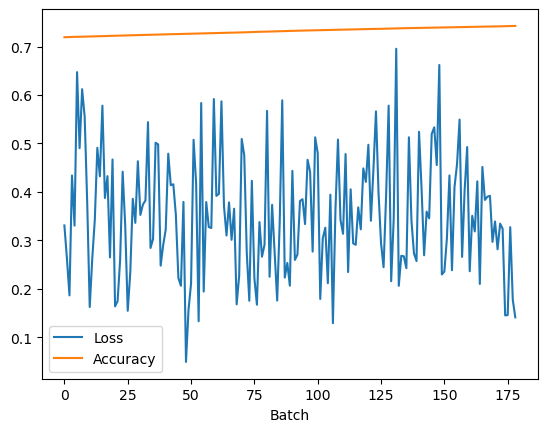

Test Batch: 0 | Test loss: 0.4189 | Test Accuracy: 74.26 %
Train Batch: 0 | Train loss: 0.1451 | Train Accuracy: 74.48 % |
Train Batch: 20 | Train loss: 0.2150 | Train Accuracy: 74.68 % |
Train Batch: 40 | Train loss: 0.3814 | Train Accuracy: 74.88 % |
Train Batch: 60 | Train loss: 0.1681 | Train Accuracy: 75.16 % |
Train Batch: 80 | Train loss: 0.1464 | Train Accuracy: 75.42 % |
Train Batch: 100 | Train loss: 0.3216 | Train Accuracy: 75.63 % |
Train Batch: 120 | Train loss: 0.5556 | Train Accuracy: 75.84 % |
Train Batch: 140 | Train loss: 0.6046 | Train Accuracy: 76.01 % |
Train Batch: 160 | Train loss: 0.1742 | Train Accuracy: 76.20 % |


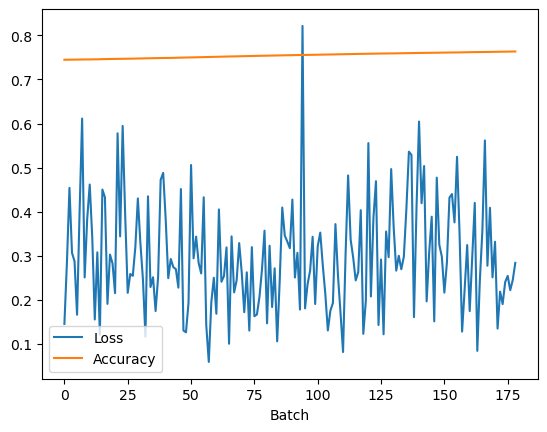

Test Batch: 0 | Test loss: 0.3731 | Test Accuracy: 76.36 %
Train Batch: 0 | Train loss: 0.4728 | Train Accuracy: 76.54 % |
Train Batch: 20 | Train loss: 0.2728 | Train Accuracy: 76.76 % |
Train Batch: 40 | Train loss: 0.3188 | Train Accuracy: 76.92 % |
Train Batch: 60 | Train loss: 0.2062 | Train Accuracy: 77.07 % |
Train Batch: 80 | Train loss: 0.2809 | Train Accuracy: 77.19 % |
Train Batch: 100 | Train loss: 0.2710 | Train Accuracy: 77.38 % |
Train Batch: 120 | Train loss: 0.2831 | Train Accuracy: 77.60 % |
Train Batch: 140 | Train loss: 0.3065 | Train Accuracy: 77.77 % |
Train Batch: 160 | Train loss: 0.5518 | Train Accuracy: 77.91 % |


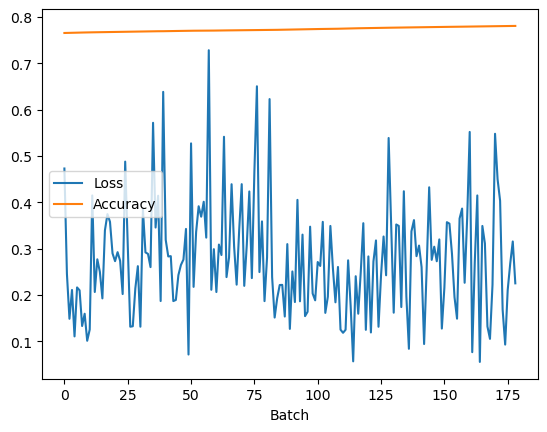

Test Batch: 0 | Test loss: 0.1813 | Test Accuracy: 78.07 %
Train Batch: 0 | Train loss: 0.5044 | Train Accuracy: 78.21 % |
Train Batch: 20 | Train loss: 0.2011 | Train Accuracy: 78.37 % |
Train Batch: 40 | Train loss: 0.1912 | Train Accuracy: 78.53 % |
Train Batch: 60 | Train loss: 0.2373 | Train Accuracy: 78.67 % |
Train Batch: 80 | Train loss: 0.2519 | Train Accuracy: 78.78 % |
Train Batch: 100 | Train loss: 0.2348 | Train Accuracy: 78.92 % |
Train Batch: 120 | Train loss: 0.2214 | Train Accuracy: 79.06 % |
Train Batch: 140 | Train loss: 0.2218 | Train Accuracy: 79.23 % |
Train Batch: 160 | Train loss: 0.3897 | Train Accuracy: 79.35 % |


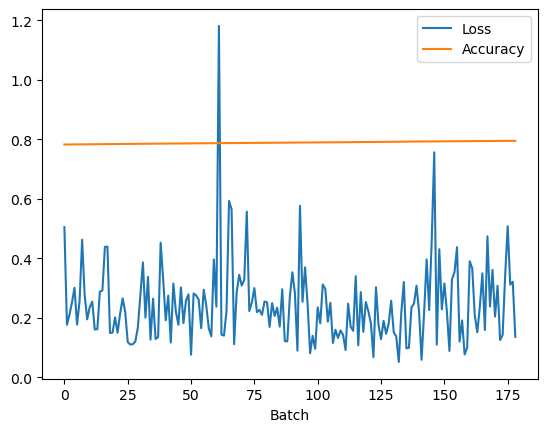

Test Batch: 0 | Test loss: 0.6294 | Test Accuracy: 79.45 %
Train Batch: 0 | Train loss: 0.1159 | Train Accuracy: 79.58 % |
Train Batch: 20 | Train loss: 0.1360 | Train Accuracy: 79.76 % |
Train Batch: 40 | Train loss: 0.0889 | Train Accuracy: 79.90 % |
Train Batch: 60 | Train loss: 0.1917 | Train Accuracy: 80.06 % |
Train Batch: 80 | Train loss: 0.2743 | Train Accuracy: 80.19 % |
Train Batch: 100 | Train loss: 0.1840 | Train Accuracy: 80.28 % |
Train Batch: 120 | Train loss: 0.0916 | Train Accuracy: 80.38 % |
Train Batch: 140 | Train loss: 0.1984 | Train Accuracy: 80.50 % |
Train Batch: 160 | Train loss: 0.2350 | Train Accuracy: 80.62 % |


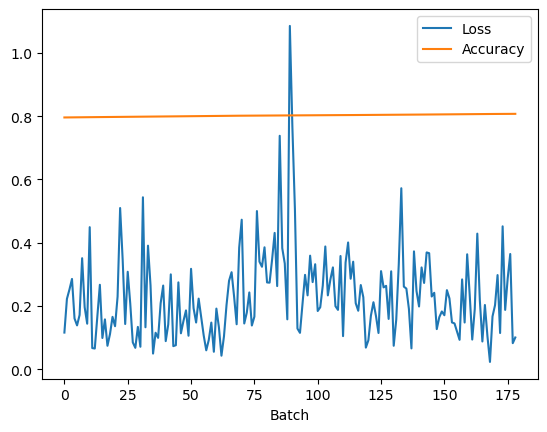

Test Batch: 0 | Test loss: 0.5174 | Test Accuracy: 80.72 %
Train Batch: 0 | Train loss: 0.2725 | Train Accuracy: 80.79 % |
Train Batch: 20 | Train loss: 0.1214 | Train Accuracy: 80.93 % |
Train Batch: 40 | Train loss: 0.0796 | Train Accuracy: 81.06 % |
Train Batch: 60 | Train loss: 0.1299 | Train Accuracy: 81.18 % |
Train Batch: 80 | Train loss: 0.2199 | Train Accuracy: 81.30 % |
Train Batch: 100 | Train loss: 0.0932 | Train Accuracy: 81.41 % |
Train Batch: 120 | Train loss: 0.0756 | Train Accuracy: 81.50 % |
Train Batch: 140 | Train loss: 0.2617 | Train Accuracy: 81.61 % |
Train Batch: 160 | Train loss: 0.1826 | Train Accuracy: 81.73 % |


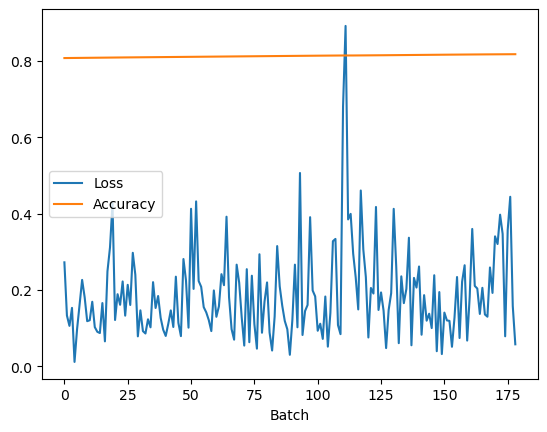

Test Batch: 0 | Test loss: 0.1761 | Test Accuracy: 81.81 %


In [21]:
epochs = 10
for epoch in tqdm(range(epochs)):
    train_step(model_retry, device, train_dataloader, loss_function, optimizer, accuracy)
    test_step(model_retry, device, test_dataloader, loss_function, accuracy)

## Model 2: Normalisation
Epochs 3, lr = 0.01, normalisation std `[0.229, 0.224, 0.225]` and mean `[0.485, 0.456, 0.406]`
### Results:
54% accuracy, much worse than the last. Don't forget to update the optimizer model parameters it's supposed to be taking

In [188]:
epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(model2, device, train_dataloader, loss_function, optimizer, accuracy)
    test_step(model2, device, test_dataloader, loss_function, accuracy)

  0%|          | 0/3 [00:00<?, ?it/s]

Train Batch: 0 | Train loss: 0.3537 | Train Accuracy: 54.17 % |
Train Batch: 20 | Train loss: 0.2425 | Train Accuracy: 54.47 % |
Train Batch: 40 | Train loss: 0.4546 | Train Accuracy: 54.76 % |
Train Batch: 60 | Train loss: 0.3271 | Train Accuracy: 55.05 % |


KeyboardInterrupt: 

## Model 3: Learning Rate Decay
`mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]`
ExponentialLR scheduler that decreases by 10x each epoch

*Results*: Final accuracy 60%, maybe with better normalisation would help more.
### Test 2: 
no normalisation, lr decay

*Results*: Hopeless. Didn't even go above 25%.

In [225]:
from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.1)  # Adjust gamma as needed

  0%|          | 0/3 [00:00<?, ?it/s]

Train Batch: 0 | Train loss: 1.4549 | Train Accuracy: 27.23 % |
Train Batch: 20 | Train loss: 1.4356 | Train Accuracy: 24.72 % |
Train Batch: 40 | Train loss: 1.4142 | Train Accuracy: 25.29 % |
Train Batch: 60 | Train loss: 1.4275 | Train Accuracy: 24.96 % |
Train Batch: 80 | Train loss: 1.4628 | Train Accuracy: 25.40 % |
Train Batch: 100 | Train loss: 1.4236 | Train Accuracy: 25.19 % |
Train Batch: 120 | Train loss: 1.3924 | Train Accuracy: 25.09 % |
Train Batch: 140 | Train loss: 1.3589 | Train Accuracy: 25.51 % |
Train Batch: 160 | Train loss: 1.4424 | Train Accuracy: 25.45 % |


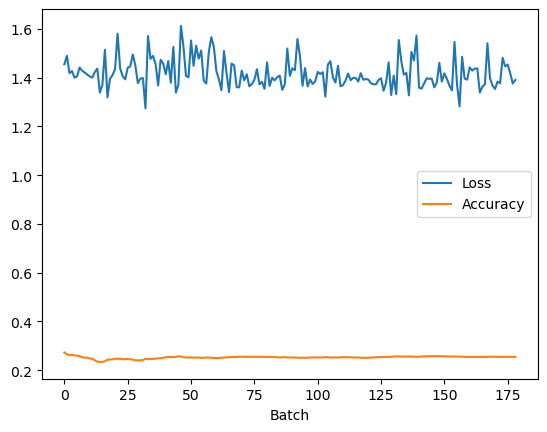

Test Batch: 0 | Test loss: 1.3452 | Test Accuracy: 25.54 %
Train Batch: 0 | Train loss: 1.3861 | Train Accuracy: 25.00 % |
Train Batch: 20 | Train loss: 1.3999 | Train Accuracy: 24.92 % |
Train Batch: 40 | Train loss: 1.4026 | Train Accuracy: 25.11 % |
Train Batch: 60 | Train loss: 1.3714 | Train Accuracy: 25.44 % |
Train Batch: 80 | Train loss: 1.3592 | Train Accuracy: 25.56 % |
Train Batch: 100 | Train loss: 1.4042 | Train Accuracy: 25.71 % |
Train Batch: 120 | Train loss: 1.3835 | Train Accuracy: 25.76 % |
Train Batch: 140 | Train loss: 1.3744 | Train Accuracy: 25.86 % |
Train Batch: 160 | Train loss: 1.3783 | Train Accuracy: 25.91 % |


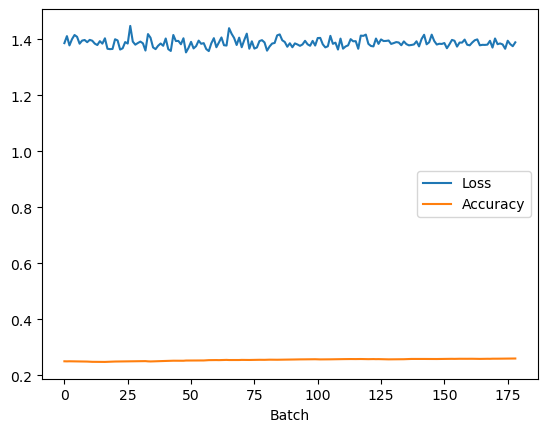

Test Batch: 0 | Test loss: 1.3876 | Test Accuracy: 26.00 %
Train Batch: 0 | Train loss: 1.3879 | Train Accuracy: 26.45 % |
Train Batch: 20 | Train loss: 1.3882 | Train Accuracy: 26.58 % |
Train Batch: 40 | Train loss: 1.3702 | Train Accuracy: 26.63 % |
Train Batch: 60 | Train loss: 1.3794 | Train Accuracy: 26.67 % |
Train Batch: 80 | Train loss: 1.3954 | Train Accuracy: 26.63 % |
Train Batch: 100 | Train loss: 1.4038 | Train Accuracy: 26.69 % |
Train Batch: 120 | Train loss: 1.3879 | Train Accuracy: 26.74 % |
Train Batch: 140 | Train loss: 1.3918 | Train Accuracy: 26.76 % |
Train Batch: 160 | Train loss: 1.3688 | Train Accuracy: 26.85 % |


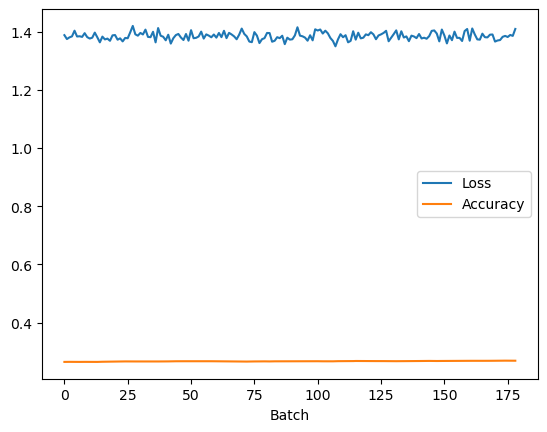

Test Batch: 0 | Test loss: 1.3745 | Test Accuracy: 26.88 %


In [226]:
epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(model3, device, train_dataloader, loss_function, optimizer, accuracy)
    test_step(model3, device, test_dataloader, loss_function, accuracy)
    scheduler.step()

## Sample Testing

In [22]:
from pathlib import Path
directory = Path('ModelSaver')
directory.mkdir(parents=True, exist_ok=True)
torch.save(model_retry.state_dict(), 'ModelSaver/NoNormal10Epoch.pth')

In [ ]:
# Old Random Image Test for Model that I functionalised elsewhere
 device = 'cpu'
from matplotlib import pyplot as plt
loaded_model = PathMNISTModel1()
loaded_model.load_state_dict(torch.load('ModelSaver/NoNormal10Epoch.pth'))
loaded_model.eval()
randidx = np.random.randint(0, len(test_data))
with torch.no_grad():
    image, answer = test_data[randidx]
    image = image.to(device)  # Move image to the same device as the model
    num_guess = loaded_model(image.unsqueeze(0)).argmax(1)
    pic = Image.open(all_image_paths[randidx])
    ans = test_data.classes[answer]
    ithink = test_data.classes[num_guess.item()]
    plt.imshow(pic)  # Move image back to CPU for plotting
    plt.axis('off')
    yes = 'g' if answer == num_guess.item() else 'r'
    plt.title(f'Actual Answer: {ans}, Guess is {ithink}', c=yes) 

In [30]:
def random_image_test(saved_model_path, test_data):
    loaded_model = PathMNISTModel1()
    loaded_model.load_state_dict(torch.load(f'ModelSaver/{saved_model_path}'))
    loaded_model.eval()
    randidx = np.random.randint(0, len(test_data))
    with torch.no_grad():
        image, answer = test_data[randidx]
        image = image.to(device)  # Move image to the same device as the model
        num_guess = loaded_model(image.unsqueeze(0)).argmax(1)
        pic = Image.open(all_image_paths[randidx])
        ans = test_data.classes[answer]
        ithink = test_data.classes[num_guess.item()]
        plt.imshow(pic)  # Move image back to CPU for plotting
        plt.axis('off')
        yes = 'g' if answer == num_guess.item() else 'r'
        plt.title(f'Actual Answer: {ans}, Guess is {ithink}', c=yes)

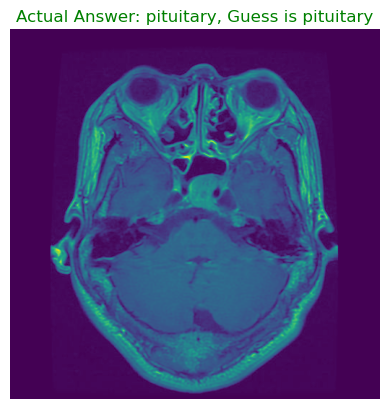

In [54]:
random_image_test('NoNormal10Epoch.pth', test_data)

In [ ]:

 from matplotlib import pyplot as plt
loaded_model = PathMNISTModel1()
loaded_model.load_state_dict(torch.load('ModelSaver/EasyNormalised5Epoch.pth'))
loaded_model.eval()
pic_number = 0

for i in range(len(test_data)):
    randidx = torch.randint(0, len(test_data), (1,))
    with torch.no_grad():
        image, answer = test_data[i]
        image = image.to(device)  # Move image to the same device as the model
        num_guess = loaded_model(image.unsqueeze(0)).argmax(1)
        if answer != num_guess.item():
            pic = Image.open(all_image_paths[i])
            ans = test_data.classes[answer]
            ithink = test_data.classes[num_guess.item()]
            plt.imshow(pic)  # Move image back to CPU for plotting
            plt.axis('off')
            yes = 'g' if answer == num_guess.item() else 'r'
            plt.title(f'Actual Answer: {ans}, Guess is {ithink} at {pic_number}', c=yes)
    pic_number += 1
 

"from matplotlib import pyplot as plt\nloaded_model = PathMNISTModel1()\nloaded_model.load_state_dict(torch.load('ModelSaver/EasyNormalised5Epoch.pth'))\nloaded_model.eval()\npic_number = 0\n\nfor i in range(len(test_data)):\n    randidx = torch.randint(0, len(test_data), (1,))\n    with torch.no_grad():\n        image, answer = test_data[i]\n        image = image.to(device)  # Move image to the same device as the model\n        num_guess = loaded_model(image.unsqueeze(0)).argmax(1)\n        if answer != num_guess.item():\n            pic = Image.open(all_image_paths[i])\n            ans = test_data.classes[answer]\n            ithink = test_data.classes[num_guess.item()]\n            plt.imshow(pic)  # Move image back to CPU for plotting\n            plt.axis('off')\n            yes = 'g' if answer == num_guess.item() else 'r'\n            plt.title(f'Actual Answer: {ans}, Guess is {ithink} at {pic_number}', c=yes)\n    pic_number += 1\n"

In [ ]:
 google_pic = Image.open(image_path/'Google'/'R.jpg')

google_trans = transform_image(google_pic)

loaded_model.eval()
with torch.no_grad():
    image = google_trans.to(device)  # Move image to the same device as the model
    num_guess = loaded_model(image.unsqueeze(0)).argmax(1)


ithink = test_data.classes[num_guess.item()]
plt.imshow(google_trans.permute(1, 2, 0))  # Move image back to CPU for plotting
plt.axis('off')
plt.title(f'Guess is {ithink}') 

"google_pic = Image.open(image_path/'Google'/'R.jpg')\n\ngoogle_trans = transform_image(google_pic)\n\nloaded_model.eval()\nwith torch.no_grad():\n    image = google_trans.to(device)  # Move image to the same device as the model\n    num_guess = loaded_model(image.unsqueeze(0)).argmax(1)\n\n\nithink = test_data.classes[num_guess.item()]\nplt.imshow(google_trans.permute(1, 2, 0))  # Move image back to CPU for plotting\nplt.axis('off')\nplt.title(f'Guess is {ithink}')"

In [45]:
mage, label = test_data[0]
name = test_data.classes[label]
plt.imshow(image.permute(1, 2, 0),)
plt.title(f'Label: {name}')

loaded_model.eval()
randidx = np.random.randint(0, len(test_data))
with torch.no_grad():
    image, label = test_data[randidx]
    image = image.unsqueeze(0)
    output = loaded_model(image).argmax()
    guess = test_data.classes[output.item()]
    print(f'Prediction: {name}')
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Prediction: {output} Answer: {label}')

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

###